## Курсовой проект

Велесов Даниил М8О-114СВ-24

Датасет **“Airline Passenger Satisfaction”** содержит 103904 строк и 25 признаков:

*  Gender - Пол пассажиров
* Customer Type
* Age - Возраст
* Type of Travel - тип полета
* Class - класс самолета
* Flight Distance - дистанция полета
* Inflight wifi service - качество Wi-Fi
* Departure/Arrival time convenient
* Ease of Online booking - легкость броинрования
* Gate location - место посадки
* Food and drink - еда и напитки
* Online boarding - онлайн бронирование
* Seat comfort - комфорт сидений
* Inflight entertainment - развлечения на борту
* On-board service - сервис на борту
* Leg room service
* Baggage handling - управка с баггажом
* Checkin service - качество проверки
* Inflight service - качество сервиса во время полета
* Cleanliness - чистота
* Departure Delay in Minutes - задержка отправки
* Arrival Delay in Minutes - задержка прибытия
* satisfaction - уровень удовлетворенности


|

In [31]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

In [32]:
class ModelML():
  def __init__(self):
    self.train = pd.read_csv('/content/train.csv')
    self.test = pd.read_csv('/content/test.csv')
    self.categorical = ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction']
    self.numeric = [elem for elem in self.train.columns if elem not in self.categorical]

  def get_info(self):
    display(self.train.head())
    print(self.train.info(), sep='\n')
    print('\nПропущенные значения', self.train.isna().sum(), sep='\n')

  def check_for_nan(self):
    print(f'train  содержит nan в столбцах {self.train.columns[self.train.isna().any()].tolist()} column')
    print(f'test содержит nan в столбцах {self.test.columns[self.test.isna().any()].tolist()} column')
    print(f"Процент nan значений в train {self.train['Arrival Delay in Minutes'].isna().sum() / self.train['Arrival Delay in Minutes'].shape[0] * 100}")
    print(f"Процент nan значений в test {self.test['Arrival Delay in Minutes'].isna().sum() / self.test['Arrival Delay in Minutes'].shape[0] * 100}")

  def detect_outliers(self):
    features = self.train.select_dtypes(exclude='object')
    Q1 = features.quantile(0.25)
    Q3 = features.quantile(0.75)
    IQR = Q3 - Q1
    print(((features < (Q1 - 1.5 * IQR)) | (features > (Q3 + 1.5 * IQR))).sum())

  def print_outliers(self):
    clmn_list = ['Flight Distance', 'Checkin service', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

    fig, axes = plt.subplots(2, 2, figsize=(10, 6))
    for i, column in enumerate(clmn_list):
        row = i // 2
        col = i % 2
        sns.boxplot(x=self.train[column], ax = axes[row, col])

    plt.tight_layout()
    plt.show()

  def describe_numeric(self):
    display(self.train[self.numeric].describe())

  def prepare_data(self):
    self.train.drop(['Unnamed: 0', 'id'], axis=1, inplace=True)
    self.test.drop(['Unnamed: 0', 'id'], axis=1, inplace=True)
    self.train.dropna(inplace=True)
    self.test.dropna(inplace=True)
    self.test['satisfaction'] = self.test['satisfaction'].map({'satisfied': 1, 'neutral or dissatisfied': 0})

  def plot_hist(self):
    for feature in ['Age', 'Flight Distance']:
      sns.histplot(self.train[[feature]], bins=20)
      plt.show()

  def plot(self):
    plt.figure(figsize=(10, 8))
    sns.histplot(data=self.train, x=self.train['Flight Distance'], kde=True, hue=self.train['satisfaction'], bins=40)
    plt.show()

  def check_classes(self):
    print(self.train['satisfaction'].value_counts())
    self.train['satisfaction'].value_counts().plot(kind='bar', title='Соотношение классов').tick_params(axis='x', rotation=0)

  def corr(self):
    features = self.train.select_dtypes(exclude='object')
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(self.train[list(features.columns)].corr(), cmap = 'coolwarm', annot = True, ax=ax)

  def get_percentage(self, variable):
    variety = self.train[variable].unique()
    for elem in variety:
        temp_series = round(self.train["satisfaction"][self.train[variable] == elem].value_counts(normalize=True), 2)
        print(f"{elem} Satisfied: {temp_series[1] * 100}% ")

  def satisfaction_by_type(self):
    self.train["satisfaction"] = self.train["satisfaction"].map({"satisfied": 1, "neutral or dissatisfied": 0})

    fig, axes = plt.subplots(1, 2, figsize=(10, 6))
    self.get_percentage('Gender')
    sns.barplot(x=self.train['Gender'], y=self.train["satisfaction"],  data=self.train, ax=axes[0]).set_title('Разделение по полу');
    self.get_percentage('Type of Travel')
    sns.barplot(x=self.train['Type of Travel'], y=self.train["satisfaction"],  data=self.train, ax=axes[1]).set_title('Разделение по типу поездки');
    plt.tight_layout()

  def model_fit_predict(self):
    self.train = pd.get_dummies(self.train)
    self.test = pd.get_dummies(self.test)
    X_train = self.train.drop('satisfaction', axis=1)
    y_train = self.train['satisfaction']

    X_test = self.test.drop('satisfaction', axis=1)
    y_test = self.test['satisfaction']
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot(cmap = plt.cm.Greens)
    print('Accuracy: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
    print('Precision: {0:0.4f}'. format(precision_score(y_test, y_pred)))
    print('Recall: {0:0.4f}'. format(recall_score(y_test, y_pred)))
    print('F1: {0:0.4f}'. format(f1_score(y_test, y_pred, average='binary')))


# data analysis & preparation

In [33]:
ml = ModelML()

In [34]:
ml.get_info()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

In [35]:
ml.check_for_nan()

train  содержит nan в столбцах ['Arrival Delay in Minutes'] column
test содержит nan в столбцах ['Arrival Delay in Minutes'] column
Процент nan значений в train 0.29835232522328303
Процент nan значений в test 0.31952571604558055


Процент значений с nan небольшой, следовательно,  в дальнейшем удалим строки с nan

In [36]:
ml.detect_outliers()

Unnamed: 0                               0
id                                       0
Age                                      0
Flight Distance                       2291
Inflight wifi service                    0
Departure/Arrival time convenient        0
Ease of Online booking                   0
Gate location                            0
Food and drink                           0
Online boarding                          0
Seat comfort                             0
Inflight entertainment                   0
On-board service                         0
Leg room service                         0
Baggage handling                         0
Checkin service                      12891
Inflight service                         0
Cleanliness                              0
Departure Delay in Minutes           14529
Arrival Delay in Minutes             13954
dtype: int64


Наблюдаем большое количество выбросов в 4х столбцах. Посмотрим на уникальные значения подробнее
* Flight Distance
* Checkin service
* Departure Delay in Minutes
* Arrival Delay in Minutes



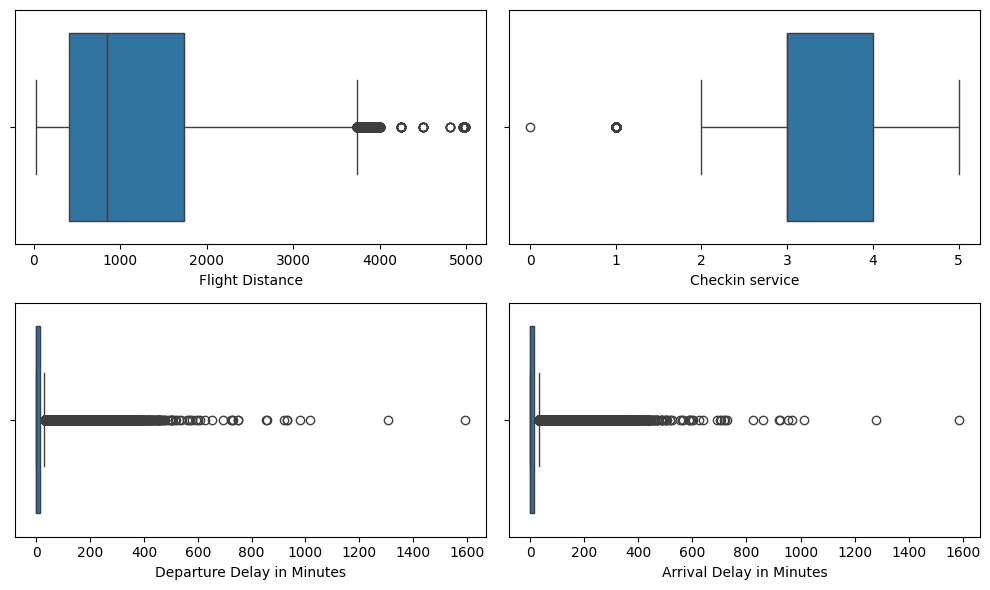

In [37]:
ml.print_outliers()

* такие данные не являются выбросами, так как все значения для всех 4х признаков могут быть в реальной жизни.

Рассчитаем основные метрики для численных столбцов

In [38]:
ml.describe_numeric()

,Unnamed: 0,id,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103594.000000
mean,51951.500000,64924.210502,39.379706,1189.448375,2.729683,3.060296,2.756901,2.976883,3.202129,3.250375,3.439396,3.358158,3.382363,3.351055,3.631833,3.304290,3.640428,3.286351,14.815618,15.178678
std,29994.645522,37463.812252,15.114964,997.147281,1.327829,1.525075,1.398929,1.277621,1.329533,1.349509,1.319088,1.332991,1.288354,1.315605,1.180903,1.265396,1.175663,1.312273,38.230901,38.698682
min,0.000000,1.000000,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25975.750000,32533.750000,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,51951.500000,64856.500000,40.000000,843.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,77927.250000,97368.250000,51.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,103903.000000,129880.000000,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


* средний уровень удовлетворенности различными аспектами обслуживания во время полета, такими как Wi-Fi, еда и напитки, развлечения на борту и т.д. составляет 3 единицы из 5
* среднее время задержки отправления и прибытия составляет ~15 минут

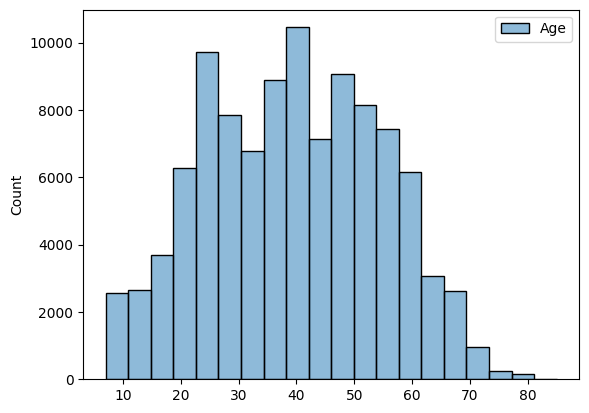

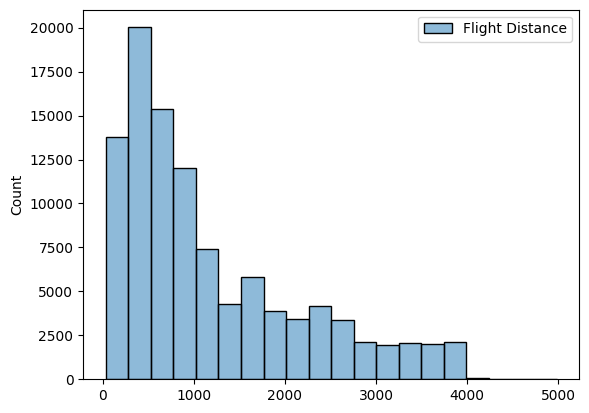

In [39]:
ml.plot_hist()

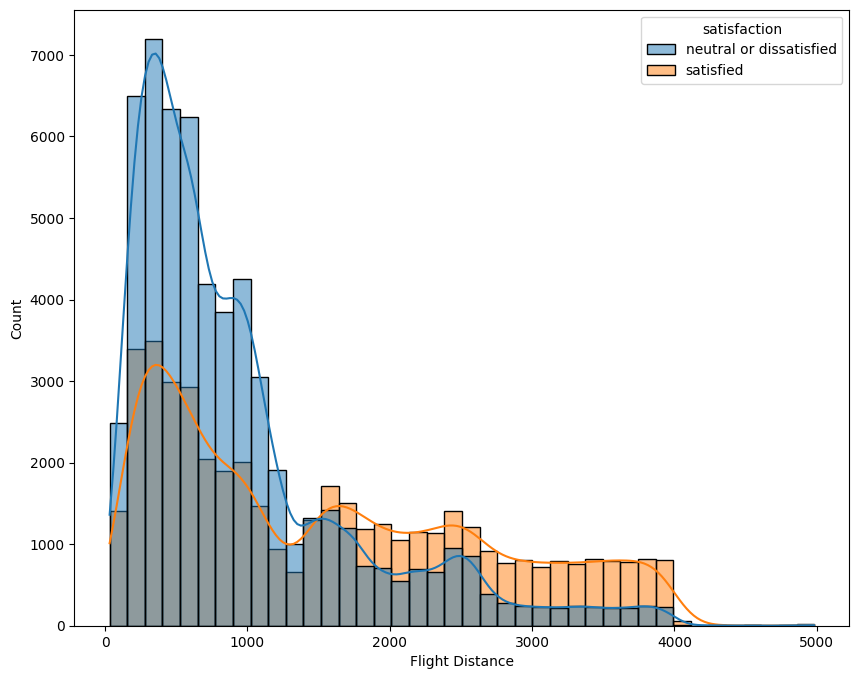

In [40]:
ml.plot()

* на дистации до 1500 км больше недовольных пассажииров, чем довольных. на дистанции свыше 1500 км ситуация противоположная

satisfaction
neutral or dissatisfied    58879
satisfied                  45025
Name: count, dtype: int64


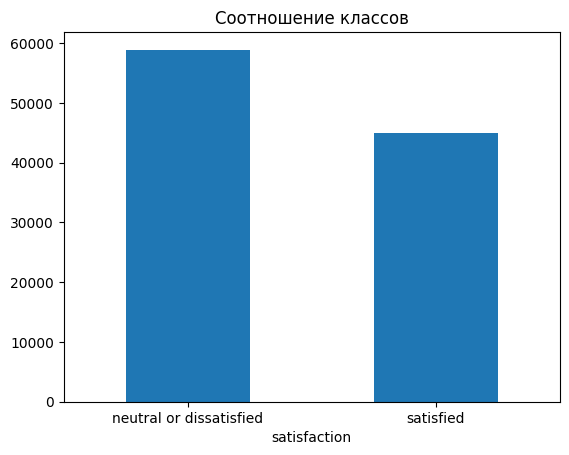

In [41]:
ml.check_classes()

Male Satisfied: 44.0% 
Female Satisfied: 43.0% 
Personal Travel Satisfied: 10.0% 
Business travel Satisfied: 57.99999999999999% 


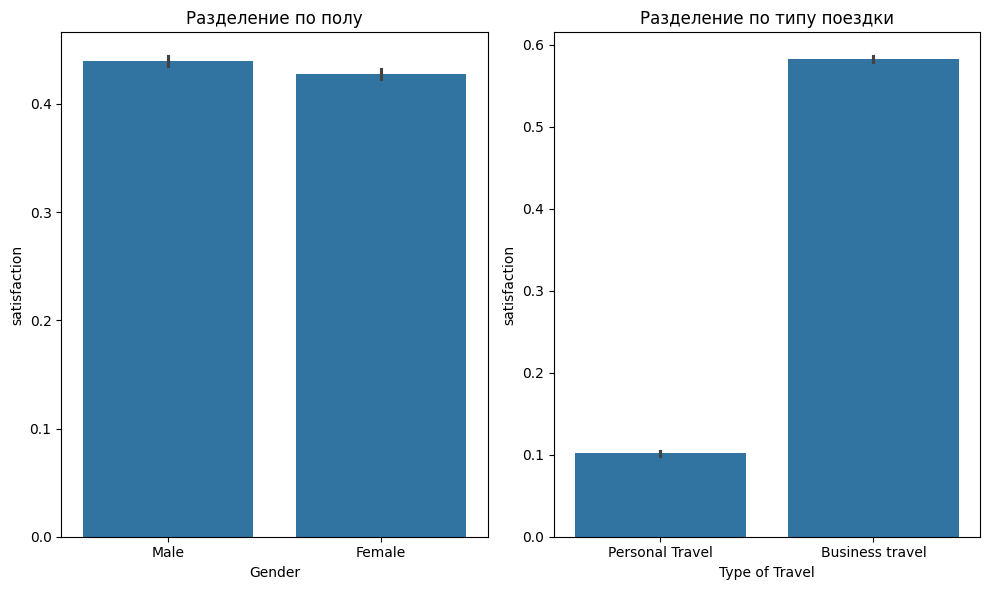

In [42]:
ml.satisfaction_by_type()

* среди всех пассажиров женщин довольны 43%
* среди всех пассажиров мужин довольны 44%
* пол не влияет на довольство полетом

* 58% пассажиров, отправляющихся в деловые поездки, довольны полетом
* 10% пассажиров, отправляющихся в личные поездки, довольны полетом
* признак «Тип путешествия» играет значительную роль в определении удовлетворенности пассажиров. \
Это может быть связано с тем, что пассажиры в командировках обычно путешествуют бизнес-классом и получают практически все удобства.


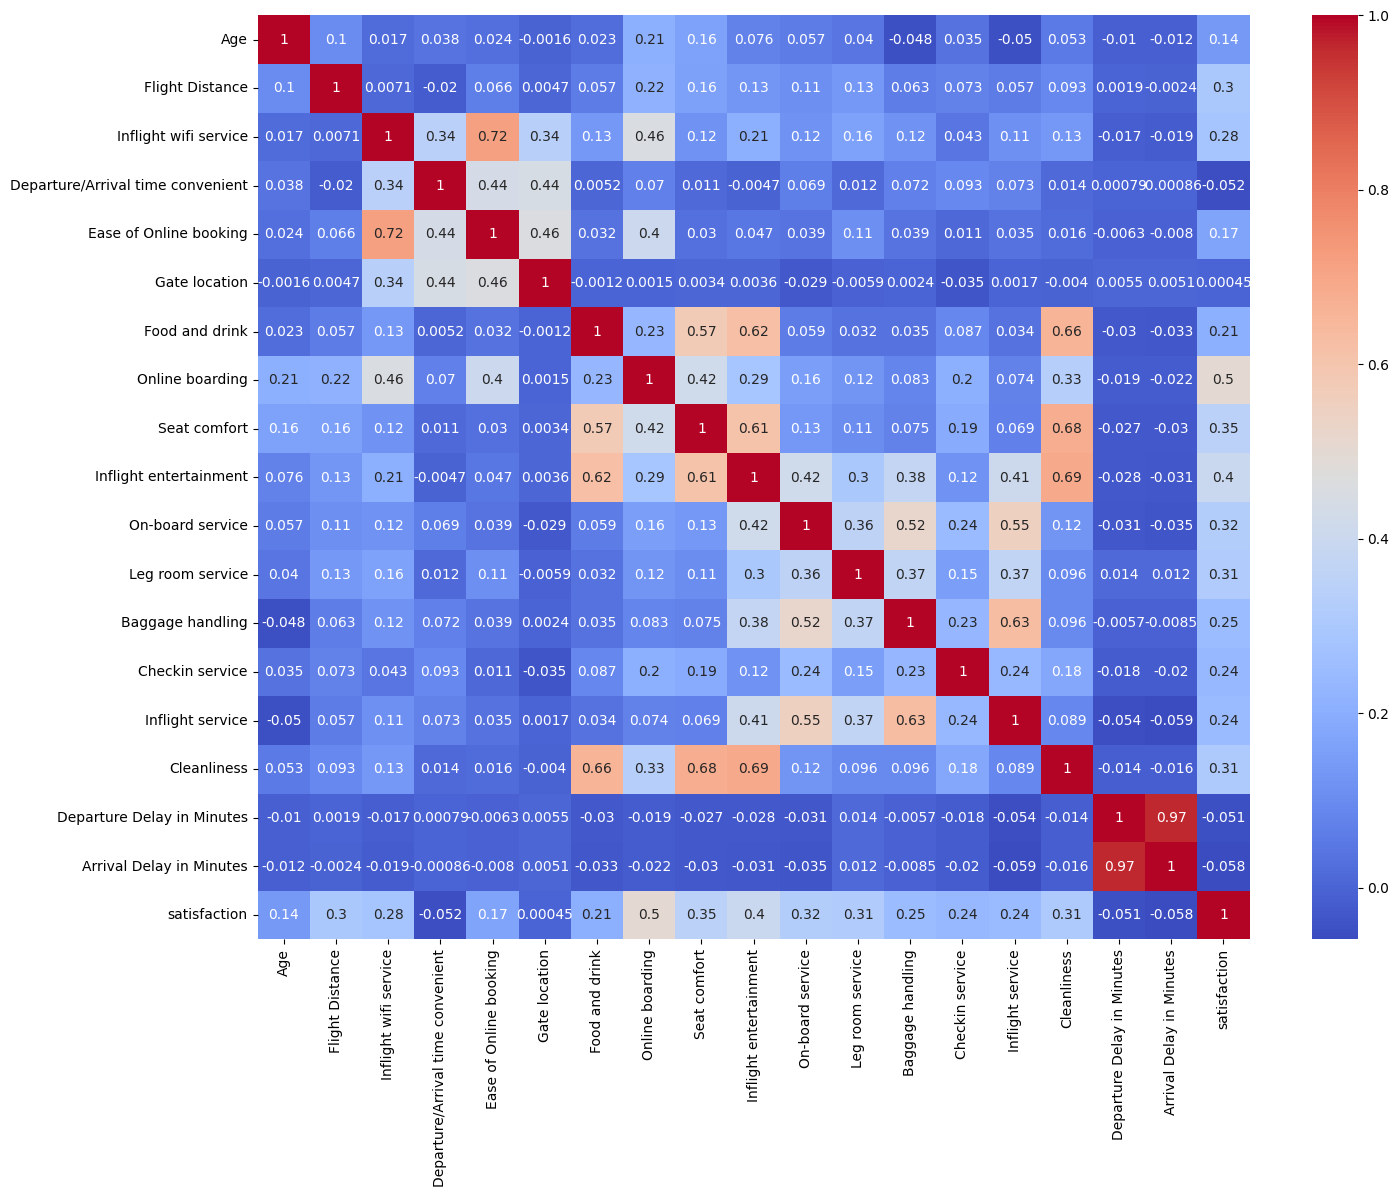

In [43]:
ml.prepare_data()
ml.corr()

Из признаков удовлетворенности различными аспектами обслуживания во время полета наиболее сильная прямая положительная корреляция наблюдается у Онлайн бронирования, досуге на борту и удобства кресел.   

Кластеризация PCA

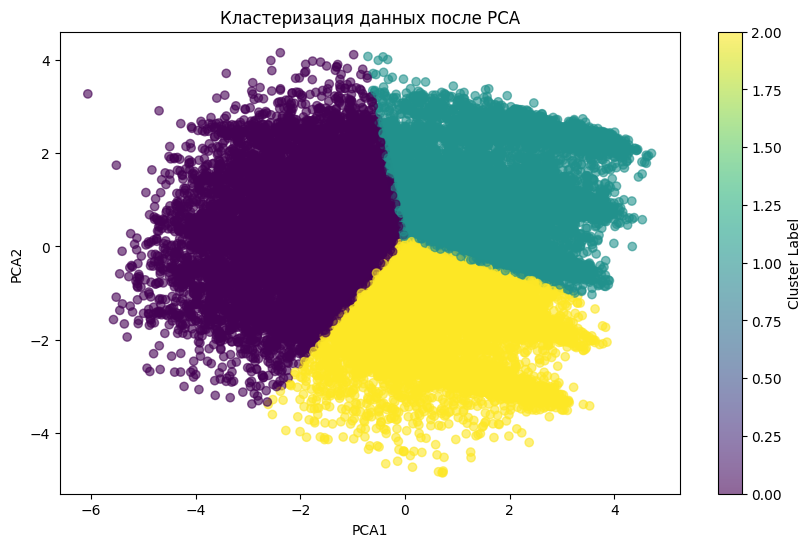

In [44]:

# Загрузка данных
df = pd.read_csv('/content/test.csv')

# Определяем числовые и категориальные признаки
numerical_columns = df.select_dtypes(include=np.number).columns.tolist()
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Обработка пропусков
numeric_imputer = SimpleImputer(strategy='mean')  # Заполнение числовых данных средним
categorical_imputer = SimpleImputer(strategy='most_frequent')  # Заполнение категориальных данных модой

df[numerical_columns] = numeric_imputer.fit_transform(df[numerical_columns])
df[categorical_columns] = categorical_imputer.fit_transform(df[categorical_columns])

# Предобработка данных
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ]
)

# Применение преобразований
features = preprocessor.fit_transform(df)

# Применение PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

# Кластеризация
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(reduced_features)

# Визуализация кластеризации с использованием PCA
plt.figure(figsize=(10, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.title("Кластеризация данных после PCA")
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.colorbar(label='Cluster Label')
plt.show()


# Обучение

Обучим модель KNN с числом соседей 5.

Accuracy: 0.9267
Precision: 0.9485
Recall: 0.8807
F1: 0.9134


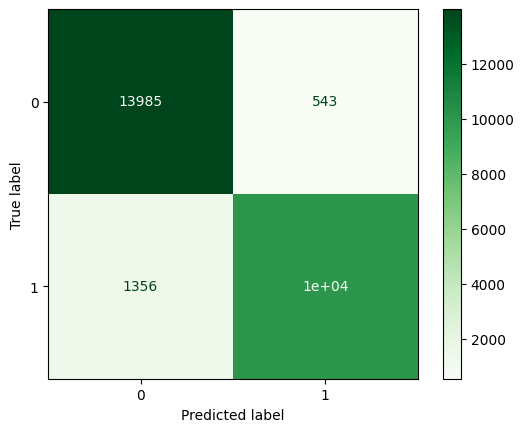

In [45]:
ml.model_fit_predict()

#ML Design и использование в продакшене

Датасет "Airline Passenger Satisfaction" может быть использован для создания ML-модели, предсказывающей удовлетворённость пассажиров авиакомпании (удовлетворён/неудовлетворён). Модель поможет авиакомпаниям выявлять ключевые факторы, влияющие на удовлетворённость, и улучшать качество услуг. Данные включают социодемографические характеристики пассажиров, детали поездки и оценки качества обслуживания, что позволяет получить комплексное понимание опыта клиента.

В продакшене модель может применяться для аналитики, персонализации обслуживания и динамической сегментации пассажиров. Например, предсказание неудовлетворённости сразу после полёта позволит авиакомпании предложить акции или улучшить взаимодействие с клиентом. Также возможно использование результатов модели для улучшения стратегических решений: анализа задержек, питания и других факторов.

Дополнительно можно расширить возможности системы за счёт учёта текстовых отзывов пассажиров или интеграции внешних данных, таких как погода или загруженность аэропортов. Такая модель станет полезным инструментом для маркетинга, отделов обслуживания клиентов и руководства авиакомпании.